# Competition: Прогнозирование оттока пользователей  
https://www.kaggle.com/c/telecom-clients-prediction2

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
import itertools
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data = pd.read_csv('orange_small_churn_data.txt')
labels = pd.read_csv('orange_small_churn_labels.txt', names = ['label'])
test = pd.read_csv('orange_small_churn_test_data.csv')
test.drop(['ID'], axis = 1, inplace = True)

In [3]:
def deleting_whole_na(data, null = 0): #удаление колонок, полностью состоящих из NaN
    if null == 0: 
        null_columns = []
        for column in data.columns:
            if not (data[column].notna()).any():
                null_columns.append(column)
    else:
        null_columns = null
    data.drop(null_columns, axis = 1, inplace = True)
    return(data, null_columns)
def deleting_na(data, columns = 0):  #удаление колонок, заполненные NaN больше чем на 20%
    if columns == 0:
        columns_with_na = [] 
        for i in data.columns[:-1]:
            if sum(data[i].value_counts())/data.shape[0] < 0.2:
                columns_with_na.append(i)
    else:
        columns_with_na = columns
    data.drop(columns_with_na, axis = 1, inplace = True)
    return(data, columns_with_na)

In [4]:
data, null_columns = deleting_whole_na(data)
data, columns_with_na = deleting_na(data)

In [5]:
test, null_columns = deleting_whole_na(test, null = null_columns)
test, columns_with_na = deleting_na(test, columns = columns_with_na)

In [6]:
def fillingin_na(data):
    for i in data.columns:
        if data[i].dtype == 'O':
            data[i].fillna('na', inplace = True)
        else:
            data[i].fillna(-999, inplace = True)
    return(data)

In [7]:
#разделяем признаки на категориальные и числовые
cat_columns = []
num_columns = []
for i in data.columns:
    if data[i].dtype == 'O':
        cat_columns.append(i)
    else:
        num_columns.append(i)
cat = data.loc[:,cat_columns]
num = data.loc[:,num_columns]

#для расчета корреляции между числовыми признаками и целевой функцией будем использовать разницу 
#мат.ожиданий классов, так как классы несбалансированы, отнормируем корреляцию с помощью стандартного отклонения
corr_num = (num[labels.label == 1].mean() - num[labels.label == -1].mean()).abs()/num.std()
corr_num = pd.DataFrame(corr_num, index = num.columns, columns = ['corr'])
#для расчета корреляции между категориальными признаками и целевой функцией будем использовать 
#коэффициент v крамера
corr_cat = []
for column in cat.columns:
    conf_matrix = pd.crosstab(cat[column], labels.label)
    corr_cat.append(np.sqrt(chi2_contingency(conf_matrix)[0]/(conf_matrix.sum().sum()*2)))
corr_cat = pd.DataFrame(corr_cat, index = cat.columns, columns = ['corr'])  

In [8]:
#удалим столбцы с корреляцией ниже 0,03
columns_with_low_corr = list(corr_num[corr_num['corr'] < 0.03].index)
columns_with_low_corr.extend(list(corr_cat[corr_cat['corr'] < 0.03].index))
data.drop(columns_with_low_corr, axis = 1, inplace = True)
test.drop(columns_with_low_corr, axis = 1, inplace = True)

In [9]:
cat_columns = []
num_columns = []
for i in data.columns:
    if data[i].dtype == 'O':
        cat_columns.append(i)
    else:
        num_columns.append(i)

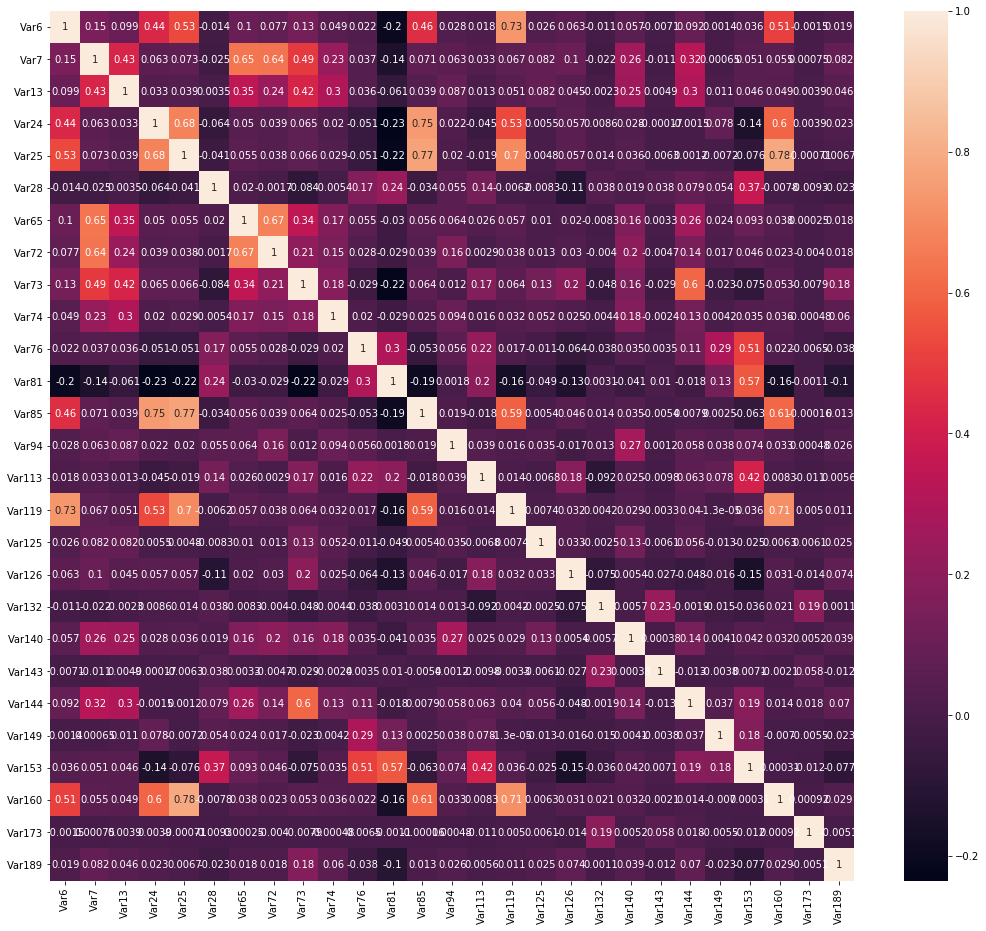

In [10]:
f, ax = plt.subplots(figsize=(18, 16))
sns.heatmap(data.loc[:,num_columns].corr(), annot = True)

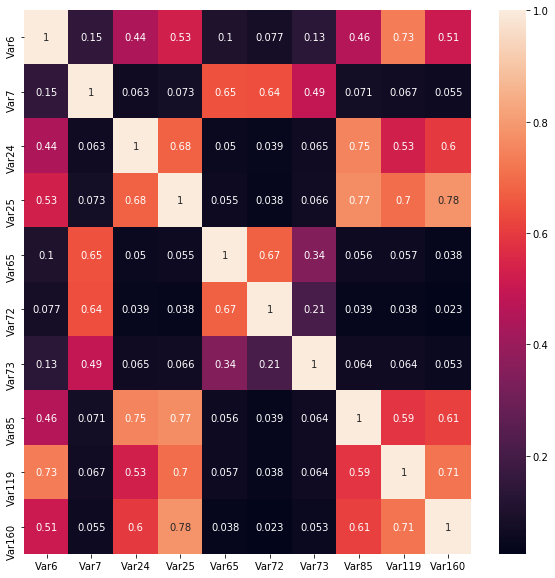

In [11]:
num = ['Var6', 'Var7', 'Var24', 'Var25','Var65', 'Var72', 'Var73', 'Var85', 'Var119', 'Var160']
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(data[num].corr(), annot = True)

In [12]:
delete = ['Var25', 'Var65', 'Var85', 'Var119', 'Var160'] #удалим сильно коррелирующие между собой признаки
data.drop(delete, axis = 1, inplace = True)
test.drop(delete, axis = 1, inplace = True)

In [13]:
data = fillingin_na(data)
test = fillingin_na(test)
# Разделение данных на тренировочную и валидационную выборки
X_train, X_test, y_train, y_test = train_test_split(data, labels.label, test_size=0.30, random_state=42)

In [14]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score

In [15]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed = 42,
    logging_level='Silent'
)

In [16]:
categorical_features_indices = np.where(data.dtypes == 'O')[0]

In [17]:
model.fit(
    X_train, y_train,
    cat_features=categorical_features_indices,
    eval_set=(X_test, y_test),
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [18]:
predictions_probs = model.predict_proba(X_test)

In [19]:
from sklearn.metrics import roc_auc_score
roc = roc_auc_score( y_test, predictions_probs.T[1])

In [20]:
roc

0.7463993515796293

In [21]:
model = CatBoostClassifier(
    custom_loss=['Accuracy'],
    random_seed=42,
    logging_level='Silent'
)

In [22]:
model.fit(
    data, labels,
    cat_features=categorical_features_indices,
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [23]:
predictions = model.predict_proba(test)

In [24]:
predicted_df = pd.DataFrame(predictions.T[1],
                            index = np.arange(len(predictions.T[1])),
                            columns=['result'])

In [25]:
predicted_df.to_csv('submission.csv')

Результат на Kaggle 0.72280